# description 4/24/19

sklearn modeling using local methods of the median imputed training data. note the preprocessing of data from 07.20-worst_case_model was performed in R (09.newagg2_preprocessing_med_impute.rmd). this eventually will be converted over to python, but for now works in r. 

preprocessing includes variable formatting (categorical to factor variables in r, train/test split, and median imputation).


In [813]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import seaborn as sns
import numpy as np
import glob
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, auc, precision_recall_fscore_support, pairwise, f1_score, log_loss
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, Imputer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils import validation
from scipy.sparse import issparse
from scipy.spatial import distance
from sklearn import svm

#importin xg boost and all needed otherstuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier #conda install -c conda-forge xgboost to install
##adding these, lets see if it helps with xgboost crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


#reducing warnings that are super common in my model
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore') #ignore all warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.filterwarnings(action='ignore', category=DeprecationWarning)


memory = Memory(cachedir='/tmp', verbose=0)
#@memory.cache above any def fxn.

RANDOM_STATE = 15485867

%matplotlib inline
plt.style.use('ggplot')

from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})




%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 74.3 ms


# functions related to gower distance, preprocessing, finding train samples, etc...

In [4]:
def _return_float_dtype(X, Y):
    ##used in grower distance, converts values to floats for formatting.
    """
    1. If dtype of X and Y is float32, then dtype float32 is returned.
    2. Else dtype float is returned.
    """
    if not issparse(X) and not isinstance(X, np.ndarray):
        X = np.asarray(X)

    if Y is None:
        Y_dtype = X.dtype
    elif not issparse(Y) and not isinstance(Y, np.ndarray):
        Y = np.asarray(Y)
        Y_dtype = Y.dtype
    else:
        Y_dtype = Y.dtype

    if X.dtype == Y_dtype == np.float32:
        dtype = np.float32
    elif X.dtype == np.object and not issparse(X):
        dtype = np.float
        for col in range(X.shape[1]):
            if not np.issubdtype(type(X[0, col]), np.number):
                dtype = np.object
                break
    else:
        dtype = np.float
    return X, Y, dtype


time: 27.9 ms


In [5]:
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    ##used in grower distance, checks x and y dimensions against each otehr.
    X, Y, dtype_float = _return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float
    
    ##Input validation on an array, list, sparse matrix or similar.
    ##By default, the input is checked to be a non-empty 2D array containing only finite values.
    
    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y

time: 22.8 ms


In [6]:
def gower_distances(X, Y=None, w=None, categorical_features=None):
    """
    Computes the gower distances between X and Y

    Read more in the :ref:`User Guide <metrics>`.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)

    Y : array-like, shape (n_samples, n_features)

    w:  array-like, shape (n_features)
    According the Gower formula, w is an attribute weight.

    categorical_features: array-like, shape (n_features)
    Indicates with True/False wheter a column is a categorical attribute.
    This is useful when categorical atributes are represented as integer
    values.

    Returns
    -------
    similarities : ndarray, shape (n_samples, )

    Notes
    ------
    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    """

    X, Y = check_pairwise_arrays(X, Y, dtype=(np.object, None)[issparse(X) or
                                                               issparse(Y)])
    rows, cols = X.shape

    if categorical_features is None:
        categorical_features = []
        for col in range(cols):
            if np.issubdtype(type(X[0, col]), np.number):
                categorical_features.append(False)
            else:
                categorical_features.append(True)
    # Calculates the normalized ranges and max values of numeric values
    ranges_of_numeric = [0.0] * cols
    max_of_numeric = [0.0] * cols
    for col in range(cols):
        if not categorical_features[col]:
            max = None
            min = None
            if issparse(X):
                col_array = X.getcol(col)
                max = col_array.max() + 0.0
                min = col_array.min() + 0.0
            else:
                col_array = X[:, col].astype(np.double)
                max = np.nanmax(col_array)
                min = np.nanmin(col_array)

            if np.isnan(max):
                max = 0.0
            if np.isnan(min):
                min = 0.0
            max_of_numeric[col] = max
            ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0

    if w is None:
        w = [1] * cols

    yrows, ycols = Y.shape

    dm = np.zeros((rows, yrows), dtype=np.double)

    for i in range(0, rows):
        j_start = i

        # for non square results
        if rows != yrows:
            j_start = 0

        for j in range(j_start, yrows):
            sum_sij = 0.0
            sum_wij = 0.0
            for col in range(cols):
                value_xi = X[i, col]
                value_xj = Y[j, col]

                if not categorical_features[col]:
                    if (max_of_numeric[col] != 0):
                        value_xi = value_xi / max_of_numeric[col]
                        value_xj = value_xj / max_of_numeric[col]
                    else:
                        value_xi = 0
                        value_xj = 0

                    if ranges_of_numeric[col] != 0:
                        sij = abs(value_xi - value_xj) / ranges_of_numeric[col]
                    else:
                        sij = 0
                    wij = (w[col], 0)[np.isnan(value_xi) or np.isnan(value_xj)]
                else:
                    sij = (1.0, 0.0)[value_xi == value_xj]
                    wij = (w[col], 0)[value_xi is None and value_xj is None]
                sum_sij += (wij * sij)
                sum_wij += wij

            if sum_wij != 0:
                dm[i, j] = (sum_sij / sum_wij)
                if j < rows and i < yrows:
                    dm[j, i] = dm[i, j]
    return dm


time: 197 ms


In [7]:
# ##testing grower distance
# x_train1=x_train.iloc[:100,1:20]
# x_train2=x_train.iloc[101:201,1:20]
# print(len(x_train1), #2715
# len(x_train2)) #2715

time: 889 µs


In [8]:
# gower_distances(X=x_train1, Y=x_train2, w=None, categorical_features=None) #works

time: 778 µs


In [9]:
def select_train_samples(sample_id, all_xy, m, time_interval):# m is number of similar cases or controls
    num_control = m   # the ratio of case and control is 1:2, 1:3,1:4
    
    ####not sure what this is doing.
    if time_interval == 24:
        top_con_variables = [False]*128
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
    else:
        top_con_variables = [False]*129  #there is another item in other hours
        mid_cat_variables = [True]*5
        age_variable = [False]
        next_cat_variables = [True]*10
        last_con_variables = [False]*2

        flag_cate_fea = top_con_variables + mid_cat_variables + age_variable + next_cat_variables + last_con_variables # 24,48, ...., Note that, the length of 24h  is different from other hours  in terms of columns
        
    ##all_xy = all_xy.fillna(np.nan) # fill empty with nan

    x_candidate_label = all_xy.loc[sample_id] # get the object sample
    x_candidate = x_candidate_label.drop('label')
    x_candidate_tem = x_candidate.as_matrix()
    testing_sample = x_candidate_tem.reshape(1, -1)  # covert into ....

    all_x_candidate_tem = all_xy.drop([sample_id], axis=0, inplace=False) # delete the object sample from whole set

# select similar cases
    all_cases = all_x_candidate_tem[all_x_candidate_tem.label == 1]
    all_cases_candidate = all_cases.drop(['label'], axis=1, inplace=False)
    gower_candidate_case = all_cases_candidate.values[:, :] # convert into ndarray

    Gower_Distance_1 = gower_distances(gower_candidate_case, testing_sample, categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_2 = list(Gower_Distance_1)
    Gower_Distance_3 = pd.Series(Gower_Distance_2, index = all_cases_candidate.index)
    Gower_Distance_4 = Gower_Distance_3.sort_values(ascending=False)

    Id_selected_cases = Gower_Distance_4.index[:m].tolist() # the id set of the top m similar samples

# select similar controls
    all_controls = all_x_candidate_tem[all_x_candidate_tem.label == 0]
    all_controls_candidate = all_controls.drop(['label'], axis=1, inplace=False)
    gower_candidate_control = all_controls_candidate.values[:, :] # convert into ndarray

    Gower_Distance_11 = gower_distances(gower_candidate_control, testing_sample,categorical_features = flag_cate_fea) # Gower_Distance_1 is ndarray
    Gower_Distance_22 = list(Gower_Distance_11)
    Gower_Distance_33 = pd.Series(Gower_Distance_22, index = all_controls_candidate.index)
    Gower_Distance_44 = Gower_Distance_33.sort_values(ascending=False)

    Id_selected_controls = Gower_Distance_44.index[:num_control].tolist() # the id set of the top m similar samples

    train_set_id = Id_selected_controls+Id_selected_cases

    train_set_id = np.array(train_set_id)
    return train_set_id

time: 94.6 ms


individualization_predictor.py:

In [10]:
#folder = '/Users/xuzhenxing/Documents/mimic_AKI_data/real_time_prediction/features/all/dropped/xy'
# folder = './xy'

def preprocessing(folder, time_interval, isnormalized=True):
    """Data preprocessing, Preprocessing  missing data with mean imputation; Normalize continous feature with MinMaxScaler;
    Normalize categorical feature with OneHotEncoder.

    Args:
        folder: dir path of source data;
        time_interval: interval of time, can be 24,48,72,96,120,144.
    Returns:
        x: features
        y: lables

    """

    all_xy = pd.read_csv(os.path.join(folder, 'all_{}hours_test_individualization_1thousand.csv'.format(time_interval)), index_col=0)
    # print (all_xy.shape)
    # print (all_xy.columns)

    medi = ['diuretics', 'nsaid', 'radio', 'angiotensin']
    pat = ['gender', 'age', 'ethnicity']
    # Total 9 comorbidity
    comm = ['congestive_heart_failure', 'peripheral_vascular', 'hypertension',
            'diabetes', 'liver_disease', 'mi', 'cad', 'cirrhosis', 'jaundice']

    # Total 8 chartevents
    chart = ['DiasBP_min', 'DiasBP_max', 'DiasBP_first', 'DiasBP_last', 'DiasBP_slope', 'DiasBP_avg',
             'Glucose_min', 'Glucose_max', 'Glucose_first', 'Glucose_last', 'Glucose_slope', 'Glucose_avg',
             'HeartRate_min', 'HeartRate_max', 'HeartRate_first', 'HeartRate_last', 'HeartRate_slope', 'HeartRate_avg',
             'MeanBP_min', 'MeanBP_max', 'MeanBP_first', 'MeanBP_last', 'MeanBP_slope', 'MeanBP_avg',
             'RespRate_min', 'RespRate_max', 'RespRate_first', 'RespRate_last', 'RespRate_slope', 'RespRate_avg',
             'SpO2_min', 'SpO2_max', 'SpO2_first', 'SpO2_last', 'SpO2_slope', 'SpO2_avg',
             'SysBP_min', 'SysBP_max', 'SysBP_first', 'SysBP_last', 'SysBP_slope', 'SysBP_avg',
             'Temp_min', 'Temp_max', 'Temp_first', 'Temp_last', 'Temp_slope', 'Temp_avg']

    # Total 12 labvents
    lab = ['BICARBONATE_first', 'BICARBONATE_last', 'BICARBONATE_min', 'BICARBONATE_max', 'BICARBONATE_avg',
           'BICARBONATE_slope', 'BICARBONATE_count',
           'BUN_first', 'BUN_last', 'BUN_min', 'BUN_max', 'BUN_avg', 'BUN_slope', 'BUN_count',
           'CHLORIDE_first', 'CHLORIDE_last', 'CHLORIDE_min', 'CHLORIDE_max', 'CHLORIDE_avg', 'CHLORIDE_slope',
           'CHLORIDE_count',
           'CREATININE_first', 'CREATININE_last', 'CREATININE_min', 'CREATININE_max', 'CREATININE_avg',
           'CREATININE_slope', 'CREATININE_count',
           'HEMOGLOBIN_first', 'HEMOGLOBIN_last', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'HEMOGLOBIN_avg',
           'HEMOGLOBIN_slope', 'HEMOGLOBIN_count',
           'INR_first', 'INR_last', 'INR_min', 'INR_max', 'INR_avg', 'INR_count',
           'PLATELET_first', 'PLATELET_last', 'PLATELET_min', 'PLATELET_max', 'PLATELET_avg', 'PLATELET_slope',
           'PLATELET_count',
           'POTASSIUM_first', 'POTASSIUM_last', 'POTASSIUM_min', 'POTASSIUM_max', 'POTASSIUM_avg', 'POTASSIUM_slope',
           'POTASSIUM_count',
           'PT_first', 'PT_last', 'PT_min', 'PT_max', 'PT_avg', 'PT_count',
           'PTT_first', 'PTT_last', 'PTT_min', 'PTT_max', 'PTT_avg', 'PTT_count',
           'WBC_first', 'WBC_last', 'WBC_min', 'WBC_max', 'WBC_avg', 'WBC_slope', 'WBC_count',
           'CALCIUM_first', 'CALCIUM_last', 'CALCIUM_min', 'CALCIUM_max', 'CALCIUM_avg', 'CALCIUM_count'
           ]

    if time_interval != 24:  # The 24h data lack of the feature 'CALCIUM_slope'
        lab.append('CALCIUM_slope')
    subset = medi + pat + comm + ['avg_urine'] + ['egfr_min'] + ['label'] # note that ['avg_urine'] + ['egfr_min'] is important, ignoring if they are empty.

    all_xy = all_xy.dropna(subset=subset)

    # print ('after dropping nan in the catergorical variables, the shape is {}'.format(all_xy.shape))

    all_conti_x = all_xy[chart + lab + ['avg_urine'] + ['egfr_min'] + ['age']]
    # print (all_conti_x.shape)
    # print (all_conti_x)
    all_categ_x = all_xy[['gender'] + ['ethnicity'] + medi + comm]
    # print (all_categ_x.shape)
    # print (all_categ_x)

    # Using mean imputer after drop the nan data in medication, patient demographic data, avg_ureine, egfr_min and label
    imp = Imputer(strategy='mean', axis=0)
    all_conti_x_fitted = imp.fit_transform(all_conti_x)

    def normalize(all_conti_x_fitted, all_categ_x):
        # using the MinMaxScaler to normalization the all_x
        min_max_scaler = MinMaxScaler()
        all_conti_x_fitted = min_max_scaler.fit_transform(all_conti_x_fitted)
        # print (all_conti_x_fitted.shape, all_conti_x_fitted)
        # all_conti_x = DataFrame(all_conti_x_fitted, columns=all_conti_x.columns)
        # print (all_conti_x.shape)

        onehot_enc = OneHotEncoder(sparse=False)  # dense format
        all_categ_x_fitted = onehot_enc.fit_transform(all_categ_x)
        # print (all_categ_x_fitted.shape, all_categ_x_fitted)
        return all_conti_x_fitted, all_categ_x_fitted

    if isnormalized:
        all_conti_x_fitted, all_categ_x_fitted = normalize(all_conti_x_fitted, all_categ_x)

    x = np.hstack((all_conti_x_fitted, all_categ_x_fitted))
    # y = all_xy['label']
    # x = np.array(x)
    # y = np.array(y)
    # print (x.shape, y.shape)
    # return x, y
    y = all_xy['label']
    z_icustay_id = y.index
    x = np.array(x)
    y = np.array(y)
    z_icustay_id = np.array(z_icustay_id)

    print (x.shape, y.shape)
    return x, y, z_icustay_id, all_xy


time: 202 ms


In [11]:
def perf_model(pipe, param_grid, name, X_train, X_test,
               y_train, y_test, scoring, verbose=0):
    gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1, verbose=verbose)
    gs.fit(X_train, y_train)

    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)

    acc_train = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test = accuracy_score(y_true=y_test, y_pred=y_test_pred)

    fpr, tpr, _ = roc_curve(y_train, gs.predict_proba(X_train)[:, 1])
    auc_train = auc(fpr, tpr)

    fpr, tpr, _ = roc_curve(y_test, gs.predict_proba(X_test)[:, 1])
    auc_test = auc(fpr, tpr)

    confmat_train = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    confmat_test = confusion_matrix(y_true=y_test, y_pred=y_test_pred)

    print (' best parameter: ', gs.best_params_)
    print (' training acc:%.2f auc:%.2f ' % (acc_train, auc_train))
    print (' testing acc:%.2f auc:%.2f ' % (acc_test, auc_test))

    print (' train confusion matrix:\n', confmat_train)
    print (' testing confusion matrix:\n', confmat_test)
    print (' classification report:\n', classification_report(y_test, y_test_pred))

    train_report = np.array(precision_recall_fscore_support(y_train, y_train_pred))
    train_class1_report = train_report[:, 1]
    train_metrics = list(train_class1_report[:-1])
    train_metrics.extend([acc_train, auc_train])
    print ('training metrics: precision, recall, f1-score, acc, auc')
    print (train_metrics)

    test_report = np.array(precision_recall_fscore_support(y_test, y_test_pred))
    test_class1_report = test_report[:, 1]
    test_metrics = list(test_class1_report[:-1])
    test_metrics.extend([acc_test, auc_test])
    print ('test metrics: precision, recall, f1-score, acc, auc')
    print (test_metrics)

    return train_metrics, test_metrics
    """
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")

    plt.plot(fpr, tpr, label="acc:%f auc:%f" % (acc_test, auc_test))
    plt.legend(loc="best")
    plt.show()
    plt.close()

    precision, recall, _ = precision_recall_curve(y_train, gs.predict_proba(X_train)[:,1])
    average_precision = average_precision_score(y_test, gs.predict_proba(X_test)[:,1])
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.step(precision, recall, where='post', label='AP={0:0.2f}'.format(average_precision))
    plt.legend(loc="best")
    plt.show()
    plt.close()
    """


time: 72.3 ms


In [12]:
def try_dbdt(X_train, X_test, y_train, y_test, scoring):
    gbm = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, min_samples_leaf=60,
                                     max_features=9, subsample=0.7, random_state=10)

    param_grid = {'max_depth': list(range(3, 14, 2)), 'min_samples_split': list(range(100, 801, 200))}
    train_metrics, test_metrics = perf_model(gbm, param_grid, 'GBDT', X_train, X_test, y_train, y_test, scoring, 0)
    return train_metrics, test_metrics

time: 4.54 ms


In [13]:
#issue im having is that 

def try_models_cross(X_train, X_test, y_train, y_test, scoring):#  select data cross 5 Fold
    # X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, stratify=Y, random_state=RANDOM_STATE)
    # """
    # print ('\n\nLinear Logistic Regression with L1 Penalty')
    # lgr_l1_train_metrics, lgr_l1_test_metrics = try_lgr_l1(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nLinear Logistic Regression with L2 Penalty')
    # lgr_l2_train_metrics, lgr_l2_test_metrics = try_lgr_l2(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nStochastic Gradient Descent')
    # Elastic_train_metrics, Elastic_test_metrics = try_sgd(X_train, X_test, y_train, y_test, scoring)
    #
    # print ('\n\nRandom Forest')
    # rf_train_metrics, rf_test_metrics = try_rf(X_train, X_test, y_train, y_test, scoring)
    # #
    print ('\n\nGradient Boosting Decision tree')
    xgboost_train_metrics, xgboost_test_metrics = try_dbdt(X_train, X_test, y_train, y_test, scoring)




time: 6.1 ms


# importing and formatting dataset

In [456]:
os.chdir('/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling') #use to change working directory
wd= os.getcwd() #'/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling'

date="04042019"
final_pt_df2 = pd.read_csv(Path(wd + '/data/raw/csv/04042019_final_pt_df2_v.csv') , index_col=0) #only for patients with minimum vitals
patients= list(final_pt_df2['subject_id'].unique())
hadm_id= list(final_pt_df2['hadm_id'].unique())
icustay_id= list(final_pt_df2['icustay_id'].unique())
icustay_id= [int(x) for x in icustay_id]

time: 262 ms


In [669]:
train_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_train.csv") #two class training data
test_data= pd.read_csv("/Users/geickelb1/Documents/GitHub/mimiciii-antibiotics-modeling/models/imputation/04042019_newagg2_median_imputed_test.csv") #two class training data

time: 104 ms


## light data reformatting for model
### most data are already converted to median type zscores, however weight and admit age still need to be converted.

In [670]:
def preprocessing(data):
    train_data=data
    weight_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).median()
    weight_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.25)#.between(train_data['col'].quantile(.25), df['col'].quantile(.75), inclusive=True)]
    weight_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","weight"]+1).quantile(0.75)
    weight_iqr=weight_quant3-weight_quant1
    #print(weight_median,weight_quant3,weight_quant1, weight_iqr)

    age_median=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).median()
    age_quant1=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.25)
    age_quant3=np.log(train_data.loc[train_data['final_bin']=="C_neg/A_partial","first_admit_age"]+1).quantile(0.75)
    age_iqr=age_quant3-age_quant1

    #converting to log scaled standardized data for age/weight
    train_data['weight']=train_data['weight'].apply(lambda x: (np.log(x+1)-weight_median)/weight_iqr)
    train_data['first_admit_age']=train_data['first_admit_age'].apply(lambda x: (np.log(x+1)-age_median)/age_iqr)
    
    ### onehot encoding categorical var
    cols_to_transform=['any_vasoactive', 'leukocyte', 'pao2fio2Ratio', 'vent_recieved']
    train_data = pd.get_dummies(train_data, columns = cols_to_transform )
    
    
    #binarizing and poping outcome for training data
    train_data.loc[train_data['final_bin']=="C_pos/A_full","final_bin"]=1
    train_data.loc[train_data['final_bin']=="C_neg/A_partial","final_bin"]=0
    train_data['final_bin']=pd.to_numeric(train_data['final_bin'])
    
    ## establishing training data and labels
    x_train= train_data.copy()
    z_icustay_id=x_train.pop('icustay_id')
    y_train= x_train.pop("final_bin").values
    
    return(x_train, y_train, z_icustay_id)

    
    
    

time: 64.5 ms


In [671]:
x_train, y_train, z_icustay_id = preprocessing(train_data)
x_test, y_test, z_icustay_id_test= preprocessing(test_data)

time: 88.8 ms


In [681]:
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9,38,39,40,41]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,[1,2,3,4,5,6,7,8,9]]).copy() #copy of x_train
#x=np.array(x_train.iloc[:,38:])
x=np.array(x_train.copy())

#x=np.array(train_data.iloc[:,[1,2,3,4]]).copy() #copy of x_train
#train_data.iloc[:,[1,2,3,4,5]] ###drastically reducing my dataframe size to test algorithm
y=y_train.copy() #copy of y_train

##all_xy: train data with finalbin:label and index=icustay_id
all_xy=train_data.copy().set_index("icustay_id").rename(columns={'final_bin':"label"}) #

time_interval=4

time: 13.1 ms


## issue found! i accidentally included my outcome in my parameters >< (fixed now)

# Modelbuilding
* step1) hypertune xgb on 5fold cv.
* step2) test entire trainset and predict trainset.
* step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

## step1) XGB hypertuning

In [682]:
def xgb_hypertuning(scale_pos_weight=1, max_depth=3, n_jobs=4, learning_rate=0.1):
    skf = StratifiedKFold(n_splits=5) #Stratified K-Folds cross-validator

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost
    cv_y= []

    for train_index, test_index in skf.split(x, y):

        xgboost_random = XGBClassifier(learning_rate=learning_rate, n_estimators=100, max_depth=max_depth,
                                min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective='binary:logistic', n_jobs=n_jobs, scale_pos_weight=scale_pos_weight, seed=27)
        
        xgboost_random.fit(x[train_index], y[train_index])
        y_pred_random = xgboost_random.predict(x[test_index])
        y_proba_random = xgboost_random.predict_proba(x[test_index])[:,1]

        xg_one_fold_pred.append(y_pred_random)
        xg_one_fold_proba.append(y_proba_random)
        cv_y.append(y[test_index])


    xg_y_individual_pred = np.array(np.concatenate(xg_one_fold_pred))
    xg_y_individual_proba = np.array(np.concatenate(xg_one_fold_proba))

    cv_y_test=np.array(np.concatenate(cv_y))

    print ('---------new fold---------------')
    print ('**** result of non-individual predictor using xgboost:')
    print ('the Accuracy of one fold:', accuracy_score(cv_y_test, xg_y_individual_pred))
    print ('the AUC of one fold:', roc_auc_score(cv_y_test, xg_y_individual_proba))
    print(confusion_matrix(cv_y_test, xg_y_individual_pred))
    print ('the classification_report :\n', classification_report(cv_y_test, xg_y_individual_pred))
    print("\n")


time: 64.9 ms


In [683]:
def svc_param_selection(X, y, nfolds, scoring="roc_auc"):
    scale_pos_weight = [0.1, 1, 5, 10]
    max_depth = [1, 2, 3, 4, 5]
    learning_rate=[0.01, 0.1, 0.5, 1]
    param_grid = {'scale_pos_weight': scale_pos_weight, 'max_depth' : max_depth, "learning_rate":learning_rate}
    grid_search = GridSearchCV(XGBClassifier(n_estimators=100, min_child_weight=2,
                                              gamma=0, subsample=0.8, colsample_bytree=0.8,
                                              objective='binary:logistic', n_jobs=-1, seed=27),
                               param_grid,
                               cv=nfolds,
                               scoring=scoring,
                              return_train_score=True)
    grid_search.fit(X, y)
    
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    
        
    #grid_search.best_params_
    print(grid_search.best_score_)
    print("\n")
    print(grid_search.best_params_)
    return(grid_search)

time: 29.2 ms


In [23]:
svc_param_selection(x, y, 10) #{'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 0.1} will use this since super close with 5 fold as well

Grid scores on development set:

0.701 (+/-0.058) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
0.723 (+/-0.056) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
0.718 (+/-0.046) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
0.712 (+/-0.047) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
0.719 (+/-0.052) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
0.740 (+/-0.047) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
0.738 (+/-0.044) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
0.735 (+/-0.040) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
0.724 (+/-0.047) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
0.748 (+/-0.047) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
0.748 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
0.746 (+/-0.043) for {'learning_rat

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'scale_pos_weight': [0.1, 1, 5, 10], 'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

time: 2min 23s


In [24]:
svc_param_selection(x, y, 5)

Grid scores on development set:

0.700 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
0.721 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
0.718 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
0.711 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
0.724 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
0.738 (+/-0.020) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
0.738 (+/-0.016) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
0.734 (+/-0.017) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
0.728 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
0.748 (+/-0.027) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
0.748 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
0.745 (+/-0.022) for {'learning_rat

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=2, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'scale_pos_weight': [0.1, 1, 5, 10], 'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

time: 57.4 s


In [680]:
test=svc_param_selection(x, y, 5, scoring="balanced_accuracy")

ValueError: feature_names may not contain [, ] or <

time: 39.4 ms


In [27]:
test=svc_param_selection(x, y, 5, scoring="recall_macro")

Grid scores on development set:

0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
0.533 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
0.580 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
0.633 (+/-0.020) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
0.500 (+/-0.000) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
0.599 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
0.647 (+/-0.022) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
0.501 (+/-0.003) for {'learning_rat

In [684]:
test=svc_param_selection(x, y, 5, scoring="neg_log_loss")

Grid scores on development set:

-0.565 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 0.1}
-0.556 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 1}
-0.738 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 5}
-0.879 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 1, 'scale_pos_weight': 10}
-0.555 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 0.1}
-0.539 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 1}
-0.706 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 5}
-0.841 (+/-0.006) for {'learning_rate': 0.01, 'max_depth': 2, 'scale_pos_weight': 10}
-0.550 (+/-0.003) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 0.1}
-0.530 (+/-0.004) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 1}
-0.686 (+/-0.002) for {'learning_rate': 0.01, 'max_depth': 3, 'scale_pos_weight': 5}
-0.813 (+/-0.005) for {'

## step 1.5, hypertune random forest as well

n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)


In [199]:
# def rf_param_selection(X, y, nfolds, scoring="roc_auc"):
#     # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#     # Number of features to consider at every split
#     max_features = ['auto', 'sqrt']
#     # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#     #max_depth.append(None)
#     # Minimum number of samples required to split a node
#     min_samples_split = [2, 5, 10]
#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = [1, 2, 4]
#     # Method of selecting samples for training each tree
#     bootstrap = [True, False]
#     # Create the random grid

#     #class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
#     class_weight= [None,{0:1, 1:4}, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]


#     param_grid = {'n_estimators': n_estimators,
#                    'max_features': max_features,
#                    'max_depth': max_depth,
#                    'min_samples_split': min_samples_split,
#                    'min_samples_leaf': min_samples_leaf,
#                    'bootstrap': bootstrap,
#                    'class_weight': class_weight}
    
    
#     grid_search = GridSearchCV(RandomForestClassifier(criterion='entropy', random_state=27),
#                            param_grid,
#                            cv=nfolds,
#                            scoring=scoring,
#                           return_train_score=True)
    
#     grid_search.fit(X, y)
    
#     print("Grid scores on development set:")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
    
#     for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
        
#     print(grid_search.best_score_)
#     print("\n")
#     print(grid_search.best_params_)
#     return(grid_search)


time: 58.9 ms


In [210]:
# n_estimators = [200,1000,2000]#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# param_grid = {#'n_estimators': n_estimators, 
#                'max_features': max_features, #works
#                'max_depth': max_depth, #works
#                'min_samples_split': min_samples_split, #works
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap,
#                'class_weight': class_weight
#              }

# grid_search = GridSearchCV(RandomForestClassifier(criterion='entropy'),
#                        param_grid,
#                        cv=3,
#                        scoring="roc_auc",
#                       return_train_score=True)

# grid_search.fit(x, y)

# print("Grid scores on development set:")
# means = grid_search.cv_results_['mean_test_score']
# stds = grid_search.cv_results_['std_test_score']

# for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))

# print(grid_search.best_score_)
# print("\n")
# print(grid_search.best_params_)

Grid scores on development set:
0.739 (+/-0.005) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
0.744 (+/-0.007) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
0.744 (+/-0.025) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10}
0.737 (+/-0.009) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}
0.738 (+/-0.016) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}
0.740 (+/-0.013) for {'bootstrap': True, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10}
0.749 (+/-0.003) for {'bootstrap': True, 'class_weight': Non

In [211]:
# print(grid_search.best_params_)

{'bootstrap': False, 'class_weight': None, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2}
time: 1.19 ms


### trying a diff rf cv strategy, uses a random search cv, which is computationally more efficient.

In [687]:
###making a parameter grid for rf
# Number of trees in random forest
#n_estimators = [100, 1000]#[int(x) for x in np.linspace(start = 10, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = [3,'auto', 10 ]
# Maximum number of levels in tree
max_depth = [5,10, 25]#[int(x) for x in np.linspace(5, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 5, 10]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid

#class_weight is either a dictionary of each class to a uniform weight for that class (e.g., {1:.9, 2:.5, 3:.01}), or is a string telling sklearn how to automatically determine this dictionary.
class_weight= [None,{0:1, 1:4}, {0:(1/np.bincount(y))[0], 1:(1/np.bincount(y))[1]}]


param_grid = {#'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}

time: 10.1 ms


In [690]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf= RandomForestClassifier(criterion='entropy')
log_loss=make_scorer(log_loss)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 50, #default = 10
                               cv = 5,
                               verbose=2,
                               random_state=27,
                               n_jobs = -1,
                              scoring= log_loss)
# Fit the random search model
rf_random.fit(x, y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 27.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'class_weight': [None, {0: 1, 1: 4}, {0: 0.000248015873015873, 1: 0.0007142857142857143}]},
          pre_dispatch='2*n_jobs', random_sta

time: 27min 17s


In [691]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

time: 5.82 ms


In [692]:
def evaluate(model, test_features, test_labels):
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    
    print ('the AUC is:', auc)
    print(confusion_matrix(test_labels, y_hat))
    
    return auc


base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(x, y)
base_auc = evaluate(base_model, x, y)

best_random = rf_random.best_estimator_
random_auc = evaluate(best_random, x, y)

print('Improvement of {:0.2f}%.'.format( 100 * (random_auc - base_auc) / base_auc))


the AUC is: 0.9658234126984128
[[4030    2]
 [  95 1305]]
the AUC is: 0.9520188492063492
[[3815  217]
 [  59 1341]]
Improvement of -1.43%.
time: 625 ms


## Hypertune SVC

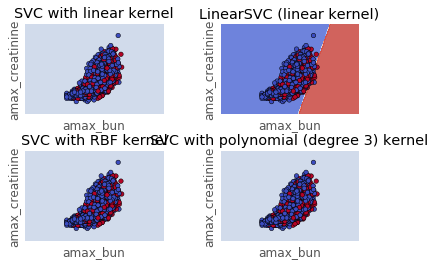

time: 6.52 s


In [790]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


# Take the first two features. We could avoid this by using a two-dim dataset
X = x[:,0:2]#iris.data[:, :2]
#y = #iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(list(x_train)[0])
    ax.set_ylabel(list(x_train)[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [809]:
kernel = ['linear', 'rbf', 'poly']
gamma = [0.1, 1, 10]
C = [0.1, 1, 10, 100]
degree = [0, 1, 2]
class_weight=['balanced', None]

param_grid = { 'kernel': kernel,
               'gamma': gamma,
               'C': C,
               'degree': degree,
                 'class_weight':class_weight}

time: 4.5 ms


In [824]:
svc= svm.SVC(probability=True)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
sv_cv = RandomizedSearchCV(estimator = svm.SVC(probability=True),
                           param_distributions = param_grid,
                           n_iter = 10, #default = 10
                           cv = 3,
                           verbose=2,
                           random_state=27,
                           n_jobs = -1,
                           scoring= 'neg_log_loss')
# Fit the random search model
sv_cv.fit(x, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10, 100], 'degree': [0, 1, 2], 'class_weight': ['balanced', None]},
          pre_dispatch='2*n_jobs', random_state=27, refit=True,
          return_train_score='warn', scoring='neg_log_loss', verbose=2)

time: 53.5 s


In [827]:
sv_cv.best_estimator_

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma=10, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

time: 2.26 ms


In [825]:
def evaluate(model, test_features, test_labels):
    y_hat = model.predict(test_features)
    errors = abs(y_hat - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    auc=roc_auc_score(test_labels, y_hat)
    
    print ('the AUC is:', auc)
    print(confusion_matrix(test_labels, y_hat))
    
    return auc


base_model = svm.SVC()
base_model.fit(x, y)
base_auc = evaluate(base_model, x, y)

best_random = sv_cv.best_estimator_
random_auc = evaluate(best_random, x, y)

print('Improvement of {:0.2f}%.'.format( 100 * (random_auc - base_auc) / base_auc))


the AUC is: 0.5635218253968255
[[3974   58]
 [1202  198]]
the AUC is: 0.7194345238095238
[[3054  978]
 [ 446  954]]
Improvement of 27.67%.
time: 2.48 s


# run hypertuned model on 5fold cv with lr and get overall metrics.
*<del> step1) hypertune xgb on 5fold cv.

* step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire trainset and predict testset.
* step4) local model testing

In [286]:
def get_auc_score(model, x=x,y=y, train_index=train_index):
    y_pred_proba = model.predict_proba(x[train_index])[:, 1] 
    roc_score=roc_auc_score(y[train_index], y_pred_proba)
    return(roc_score)

time: 2.37 ms


In [828]:
#handwritten cv function
skf = StratifiedKFold(n_splits=5) #Stratified K-Folds cross-validator

xg_cv_auc = [] # xg auc of each cv rep
xg_cv_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_cv_auc = [] # lr auc of each cv rep
lr_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

rf_cv_auc = [] # rf1 auc of each cv rep
rf_cv_proba = [] # obtain the proba  of testing samples for one fold using lr

svc_cv_auc = [] # rf1 auc of each cv rep
svc_cv_proba = [] # obtain the proba  of testing samples for one fold using lr


cv_y= []

for train_index, test_index in skf.split(x, y):   
    xgboost = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
                            min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                            objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
    #xgboost
    xgboost.fit(x[train_index], y[train_index])
    xgboost_auc= get_auc_score(xgboost, x=x,y=y, train_index=train_index)
    xgboost_pred_proba = xgboost.predict_proba(x[test_index])[:, 1]
    
    xg_cv_auc.append(xgboost_auc)
    xg_cv_proba.append(xgboost_pred_proba)
   
    #logistic reg
    logreg= LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                            intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(x[train_index], y[train_index])
    logreg_auc= get_auc_score(logreg, x=x,y=y, train_index=train_index)
    logreg_pred_proba = logreg.predict_proba(x[test_index])[:, 1] 
    
    lr_cv_auc.append(logreg_auc)
    lr_cv_proba.append(logreg_pred_proba)
    
    ###random forest: had two very different best hyperparameters via 2 different cv methods.
    rf= RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
                criterion='entropy', max_depth=10, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_impurity_split=None, min_samples_leaf=2,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=600, n_jobs=None, oob_score=False,
                random_state=None, verbose=0, warm_start=False)
    
    rf.fit(x[train_index], y[train_index])
    rf_auc= get_auc_score(rf, x=x,y=y, train_index=train_index)
    rf_pred_proba = rf.predict_proba(x[test_index])[:, 1]   

    rf_cv_auc.append(rf_auc)
    rf_cv_proba.append(rf_pred_proba)
    
    
    svc= svm.SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
                  decision_function_shape='ovr', degree=2, gamma=10, kernel='linear',
                  max_iter=-1, probability=True, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)
    svc.fit(x[train_index], y[train_index])
    svc_auc= get_auc_score(svc, x=x,y=y, train_index=train_index)
    svc_pred_proba = svc.predict_proba(x[test_index])[:, 1] 
    
    svc_cv_auc.append(svc_auc)
    svc_cv_proba.append(svc_pred_proba)
    

    cv_y.append(y[test_index])
    
#xg_cv_auc_all= np.array(np.concatenate(xg_cv_auc))
xg_cv_proba= np.array(np.concatenate(xg_cv_proba))

#lr_cv_auc_all= np.array(np.concatenate(lr_cv_auc))
lr_cv_proba= np.array(np.concatenate(lr_cv_proba))

#rf1_cv_auc_all= np.array(np.concatenate(rf1_cv_auc))
rf_cv_proba= np.array(np.concatenate(rf_cv_proba))

svc_cv_proba= np.array(np.concatenate(svc_cv_proba))


cv_y_test=np.array(np.concatenate(cv_y))
one_fold_y_test = y[test_index]

print(pd.DataFrame({'xg':xg_cv_auc, 'lr':lr_cv_auc, 'rf':rf_cv_auc, 'svc':svc_cv_auc}))

         xg        lr        rf       svc
0  0.838735  0.790624  0.996436  0.786382
1  0.834156  0.784457  0.995357  0.779798
2  0.837284  0.789869  0.995180  0.784686
3  0.842620  0.793512  0.995233  0.788870
4  0.836418  0.788956  0.995066  0.783122
time: 1min 19s


In [623]:
# def classifier_eval2(y_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True):
#     import sklearn.metrics as metrics

#     """
#     modified classifier_eval except doesn't require a model input, just a y_proba. easier to eval models w/ cv this way
#     youden's J statistic:
#     J= sensitivity + specificity -1
#     (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
#     this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
#     """
#     y_pred=[1 if y >= 0.5 else 0 for y in y_proba]

#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)

#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
#     #plotting roc
#     #plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    
#     #plt.subplot(1, 2, 1)
  
#     plt.title('ROC with optimal Youden Index')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    
# #     if print_default==True: 
# #         #plotting confusion matrixs
# #         print("\n******* Using 0.5 Classification Threshold *******")
# #         np.set_printoptions(precision=2)
# #         plt.subplot(1, 2, 1)
# #         plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
# #         plt.show()
# #         if print_classification_table==True:
# #             print ('the Accuracy is:',accuracy_score(y, y_pred))
# #             print ('the classification_report:\n', classification_report(y,y_pred))
# #         else:
# #             pass
# #     else:
# #         pass
    
#     fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

#     #plotting confusion matrixs
#     print("\n******* Using 0.5 Classification Threshold *******")
#     np.set_printoptions(precision=2)
#     plt.subplot(1, 2, 1)
#     ax=plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
#     #plt.show()
#     print ('the Accuracy is:',accuracy_score(y, y_pred))
#     print ('the classification_report:\n', classification_report(y,y_pred))

    
#     print("\n******* Using Optimal Youden Classification Threshold *******")
#     print("the Youden optimal index is : {:01.2f}".format(youden_threshold))
#     y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
#     plt.subplot(1, 2, 2)
    
#     ax2=plot_confusion_matrix(y, y_pred_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
#     plt.show()
    
#     if print_classification_table==True:
#         print ('the Accuracy is:',accuracy_score(y, y_pred_youden))
#         print ('the classification_report:\n', classification_report(y,y_pred_youden))      
#     else:
#         pass
    

time: 142 ms


In [876]:
def classifier_eval2(y_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True):
    import sklearn.metrics as metrics

    """
    modified classifier_eval except doesn't require a model input, just a y_proba. easier to eval models w/ cv this way
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    y_pred=[1 if y >= 0.5 else 0 for y in y_proba]

    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    #plotting confusion matrixs
   
    print("\n******* Using 0.5 Classification Threshold *******")
    np.set_printoptions(precision=2)
    print(confusion_matrix(y, y_pred))
    #plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
#     plt.show()
    print ('the Accuracy is:',accuracy_score(y, y_pred))
    print("npv: ", (confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0))*100)
    print ('the classification_report:\n', classification_report(y,y_pred))


    
    print("\n******* Using Optimal Youden Classification Threshold *******")
    print("the Youden optimal index is : {:01.2f}".format(youden_threshold))
    y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
    #plt.sca(axarr[0, 2])   
    #plot_confusion_matrix(y, y_pred_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
    print(confusion_matrix(y, y_pred_youden))
    #plt.show()
    
    if print_classification_table==True:
        print ('the Accuracy is:',accuracy_score(y, y_pred_youden))
        print("npv: ", (confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0))*100)
        print ('the classification_report:\n', classification_report(y,y_pred_youden))
    else:
        pass
    

time: 62.9 ms


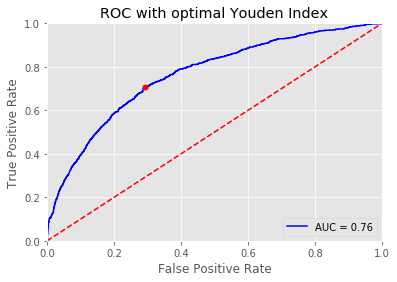


******* Using 0.5 Classification Threshold *******
[[3754  278]
 [ 948  452]]
the Accuracy is: 0.774300441826215
npv:  79.8383666524883
the classification_report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      4032
           1       0.62      0.32      0.42      1400

   micro avg       0.77      0.77      0.77      5432
   macro avg       0.71      0.63      0.64      5432
weighted avg       0.75      0.77      0.75      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.24
[[2849 1183]
 [ 410  990]]
the Accuracy is: 0.7067378497790869
npv:  87.41945382019024
the classification_report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78      4032
           1       0.46      0.71      0.55      1400

   micro avg       0.71      0.71      0.71      5432
   macro avg       0.66      0.71      0.67      5432
weighted avg       0.77

In [877]:
classifier_eval2(y_proba=svc_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

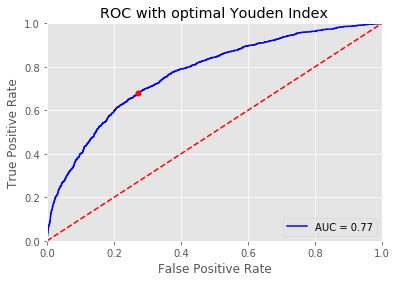


******* Using 0.5 Classification Threshold *******
[[3765  267]
 [ 957  443]]
the Accuracy is: 0.7746686303387335
npv:  79.73316391359594
the classification_report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86      4032
           1       0.62      0.32      0.42      1400

   micro avg       0.77      0.77      0.77      5432
   macro avg       0.71      0.63      0.64      5432
weighted avg       0.75      0.77      0.75      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.25
[[2934 1098]
 [ 446  954]]
the Accuracy is: 0.7157584683357879
npv:  86.80473372781064
the classification_report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.79      4032
           1       0.46      0.68      0.55      1400

   micro avg       0.72      0.72      0.72      5432
   macro avg       0.67      0.70      0.67      5432
weighted avg       0.

In [878]:
#testing classifier_eval2
#fig, axarr = plt.subplots(2, 3)     # 6 axes, returned as a 2-d array
classifier_eval2(y_proba=xg_cv_proba, x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)
#plt.show()

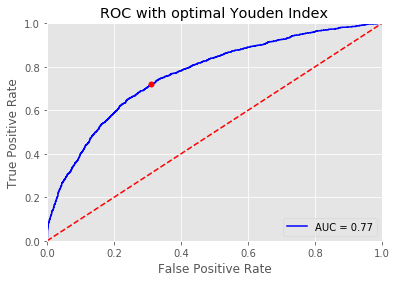


******* Using 0.5 Classification Threshold *******
[[2968 1064]
 [ 462  938]]
the Accuracy is: 0.7190721649484536
npv:  86.53061224489797
the classification_report:
               precision    recall  f1-score   support

           0       0.87      0.74      0.80      4032
           1       0.47      0.67      0.55      1400

   micro avg       0.72      0.72      0.72      5432
   macro avg       0.67      0.70      0.67      5432
weighted avg       0.76      0.72      0.73      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.46
[[2784 1248]
 [ 391 1009]]
the Accuracy is: 0.6982695139911634
npv:  87.68503937007874
the classification_report:
               precision    recall  f1-score   support

           0       0.88      0.69      0.77      4032
           1       0.45      0.72      0.55      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.66      0.71      0.66      5432
weighted avg       0.

In [879]:
classifier_eval2(y_proba=lr_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

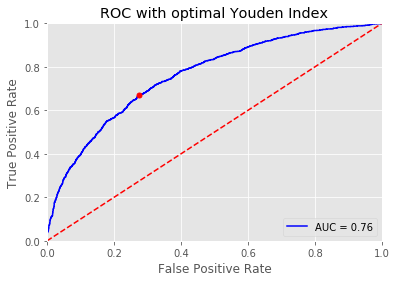


******* Using 0.5 Classification Threshold *******
[[3205  827]
 [ 593  807]]
the Accuracy is: 0.7385861561119293
npv:  84.38651922064244
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      4032
           1       0.49      0.58      0.53      1400

   micro avg       0.74      0.74      0.74      5432
   macro avg       0.67      0.69      0.68      5432
weighted avg       0.75      0.74      0.74      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.46
[[2919 1113]
 [ 461  939]]
the Accuracy is: 0.7102356406480118
npv:  86.36094674556213
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.79      4032
           1       0.46      0.67      0.54      1400

   micro avg       0.71      0.71      0.71      5432
   macro avg       0.66      0.70      0.67      5432
weighted avg       0.

In [880]:
classifier_eval2(y_proba=rf_cv_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

# testing global model

## test entire trainset and predict trainset.
<del> * step1) hypertune xgb on 5fold cv.
    
<del> * step2) run hypertuned model on 5fold cv with lr and get overall metrics.
* step3) test entire train set and predict testset.
* step4) local model testing

In [714]:
#nicer confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, #classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    import matplotlib.pyplot as plt
    from sklearn import datasets
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes,
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.grid(False) #remove gridlines for readability
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return (ax)


time: 59.6 ms


thresholds: 
* Decreasing thresholds on the decision function used to compute
    fpr and tpr. `thresholds[0]` represents no instances being predicted
    and is arbitrarily set to `max(y_score) + 1`.


In [715]:
#breaking this up into compartmentalized fxns
#def youden_index(y, y_hat_prob, pos_label=1)
def optimal_youden_index(fpr, tpr, thresholds):
    #making dataframe out of the thresholds
    roc_df= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
    roc_df.iloc[0,0] =1
    roc_df['yuden']= roc_df['tpr']-roc_df['fpr']
    idx=roc_df['yuden'].idxmax() #MAX INDEX
    
    youden_threshold=roc_df.iloc[idx,0] #threshold for max youden
    return(youden_threshold, roc_df, idx)
    

time: 6.49 ms


In [716]:
def plot_roc(fpr, tpr, roc_auc, roc_df, idx):
    plt.title('ROC with optimal Youden Index')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot(roc_df.iloc[idx,1], roc_df.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

time: 9.84 ms


In [895]:
def classifier_eval(model, x=x, y=y, pos_label=1, print_default=True):
    import sklearn.metrics as metrics

    """
    youden's J statistic:
    J= sensitivity + specificity -1
    (truepos/ truepos+falseneg) + (true neg/ trueneg + falsepos) -1
    
    this fxn is used to plot the classification model evaluation using both the 0.5 cutoff and the optimal youden cutoff for a given model
    
    """
    
    y_pred = model.predict(x)
    y_proba = model.predict_proba(x)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
    youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds)
    
    #plotting roc
    plot_roc(fpr, tpr, roc_auc, roc_df, idx)
    
    if print_default==True: 
        #plotting confusion matrixs
        print("\n******* Using 0.5 Classification Threshold *******\n")
        #np.set_printoptions(precision=2)
        #plot_confusion_matrix(y, y_pred, title='Confusion matrix, 0.5 Prob')
        #plt.show()
        print(confusion_matrix(y, y_pred))
        print ('the Accuracy is: {:01.2f}'.format(accuracy_score(y, y_pred)))
        print ("npv: {:01.2f}".format(confusion_matrix(y, y_pred)[0,0]/sum(np.array(y_pred)==0)*100))
        print ('the classification_report:\n', classification_report(y,y_pred))
    else:
        pass
    
    print("\n******* Using Optimal Youden Classification Threshold *******\n")
    print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))

    y_pred_youden= [1 if y >= youden_threshold else 0 for y in y_proba]
    
#     plot_confusion_matrix(y, y_pred_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
#     plt.show()
   
    print(confusion_matrix(y, y_pred_youden))
    print("the Accuracy is: {:01.2f}".format(accuracy_score(y, y_pred_youden)))
    print("npv: {:01.2f}".format(confusion_matrix(y, y_pred_youden)[0,0]/sum(np.array(y_pred_youden)==0)*100))
    print ('the classification_report:\n', classification_report(y,y_pred_youden))
    

time: 64.4 ms


### model fitting

In [711]:

xgboost = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3,
                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
xgboost.fit(x, y)

logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                        intercept_scaling=1, class_weight='balanced', random_state=None)

logreg.fit(x, y)

rf= RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
rf.fit(x,y)

from sklearn.naive_bayes import GaussianNB
gnb =GaussianNB()
nb_y_pred = gnb.fit(x, y)

from sklearn import svm
svc= svm.SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
              decision_function_shape='ovr', degree=2, gamma=10, kernel='linear',
              max_iter=-1, probability=True, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
svc.fit(x, y)

RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 4},
            criterion='entropy', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

time: 12.8 s


### global model test set evaluation

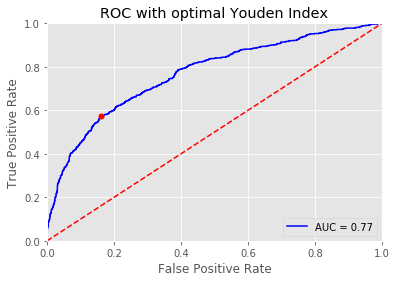


******* Using 0.5 Classification Threshold *******

[[1257  429]
 [ 220  422]]
the Accuracy is: 0.72
npv: 85.10
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.79      1686
           1       0.50      0.66      0.57       642

   micro avg       0.72      0.72      0.72      2328
   macro avg       0.67      0.70      0.68      2328
weighted avg       0.75      0.72      0.73      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.34
[[1414  272]
 [ 274  368]]
the Accuracy is: 0.77
npv: 83.77
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1686
           1       0.57      0.57      0.57       642

   micro avg       0.77      0.77      0.77      2328
   macro avg       0.71      0.71      0.71      2328
weighted avg       0.77      0.77      0.77      2328

time: 741 ms


In [903]:
classifier_eval(svc, x=np.array(x_test), y=y_test)

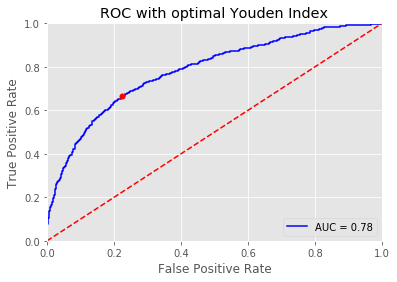


******* Using 0.5 Classification Threshold *******

[[1585  101]
 [ 409  233]]
the Accuracy is: 0.78
npv: 79.49
the classification_report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86      1686
           1       0.70      0.36      0.48       642

   micro avg       0.78      0.78      0.78      2328
   macro avg       0.75      0.65      0.67      2328
weighted avg       0.77      0.78      0.76      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.27
[[1308  378]
 [ 215  427]]
the Accuracy is: 0.75
npv: 85.88
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1686
           1       0.53      0.67      0.59       642

   micro avg       0.75      0.75      0.75      2328
   macro avg       0.69      0.72      0.70      2328
weighted avg       0.77      0.75      0.75      2328

time: 440 ms


In [896]:
classifier_eval(xgboost, x=np.array(x_test), y=y_test)

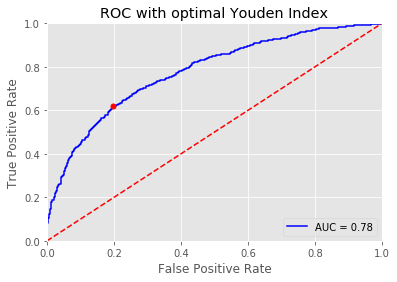


******* Using 0.5 Classification Threshold *******

[[1373  313]
 [ 260  382]]
the Accuracy is: 0.75
npv: 84.08
the classification_report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      1686
           1       0.55      0.60      0.57       642

   micro avg       0.75      0.75      0.75      2328
   macro avg       0.70      0.70      0.70      2328
weighted avg       0.76      0.75      0.76      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.49
[[1355  331]
 [ 244  398]]
the Accuracy is: 0.75
npv: 84.74
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82      1686
           1       0.55      0.62      0.58       642

   micro avg       0.75      0.75      0.75      2328
   macro avg       0.70      0.71      0.70      2328
weighted avg       0.76      0.75      0.76      2328

time: 793 ms


In [897]:
classifier_eval(rf, x=x_test, y=y_test)

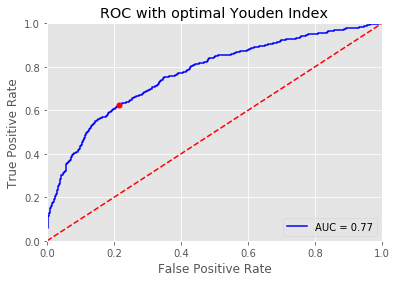


******* Using 0.5 Classification Threshold *******

[[1232  454]
 [ 214  428]]
the Accuracy is: 0.71
npv: 85.20
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.73      0.79      1686
           1       0.49      0.67      0.56       642

   micro avg       0.71      0.71      0.71      2328
   macro avg       0.67      0.70      0.67      2328
weighted avg       0.75      0.71      0.72      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.55
[[1326  360]
 [ 240  402]]
the Accuracy is: 0.74
npv: 84.67
the classification_report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      1686
           1       0.53      0.63      0.57       642

   micro avg       0.74      0.74      0.74      2328
   macro avg       0.69      0.71      0.69      2328
weighted avg       0.76      0.74      0.75      2328

time: 200 ms


In [898]:
classifier_eval(logreg, x=x_test, y=y_test)

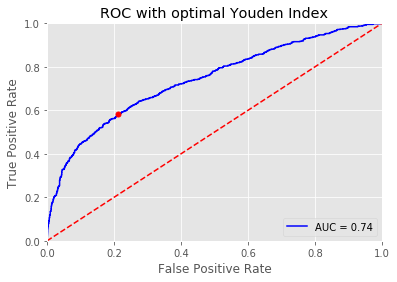


******* Using 0.5 Classification Threshold *******

[[1332  354]
 [ 273  369]]
the Accuracy is: 0.73
npv: 82.99
the classification_report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1686
           1       0.51      0.57      0.54       642

   micro avg       0.73      0.73      0.73      2328
   macro avg       0.67      0.68      0.68      2328
weighted avg       0.74      0.73      0.74      2328


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.47
[[1328  358]
 [ 268  374]]
the Accuracy is: 0.73
npv: 83.21
the classification_report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      1686
           1       0.51      0.58      0.54       642

   micro avg       0.73      0.73      0.73      2328
   macro avg       0.67      0.69      0.68      2328
weighted avg       0.74      0.73      0.74      2328

time: 185 ms


In [899]:
classifier_eval(gnb, x=x_test, y=y_test)

In [188]:
rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=27, verbose=0, warm_start=False)

time: 2.64 ms


# abandoned: making a classifier scorer method which 
* at first (#1) will try to maximize the accuracy at optimal youden index classification threshold.  
* once above works, will try to minimize the difference between (min(diagonal)-max(offdiagonal)) of confusion matrix.

this will be used in cv to best hyperparameterize

score_func : callable,
Score function (or loss function) with signature score_func(y, y_pred, **kwargs).

In [359]:
# def youden_scorer(y, y_pred, pos_label=1):
#     #y_proba, x=x, y=y, pos_label=1
#     import sklearn.metrics as metrics
    
#     y_proba=y_pred.copy()
#     fpr, tpr, thresholds = metrics.roc_curve(y, y_proba, pos_label=pos_label)
#     roc_auc = metrics.auc(fpr, tpr)

#     #gathering the optimal youden_index and df of tpr/fpr for auc and index of that optimal youden
#     youden_threshold, roc_df, idx= optimal_youden_index(fpr, tpr, thresholds) #can optimize by removing roc_df, idx
#     del(roc_df, idx)
    
#     #******* Using Optimal Youden Classification Threshold *******
#     y_pred= [1 if y >= youden_threshold else 0 for y in y_proba]
#     accuracy_score=accuracy_score(y, y_pred)
#     return(accuracy_score)


time: 11.1 ms


In [361]:
# from sklearn.metrics import make_scorer
# scorer=make_scorer(youden_scorer)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)

UnboundLocalError: local variable 'accuracy_score' referenced before assignment

time: 125 ms


In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state = 2)
# clf.fit(X_train,y_train)
# # y_pred = clf.predict(X_test)  # default threshold is 0.5
# y_pred = (clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool) # set threshold as 0.3

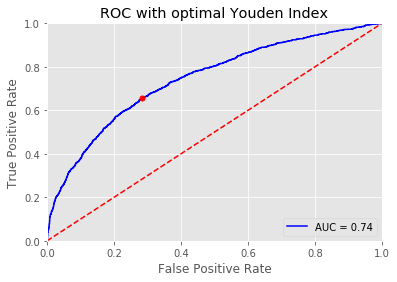


******* Using 0.5 Classification Threshold *******

Confusion matrix, without normalization
[[2874 1158]
 [ 478  922]]


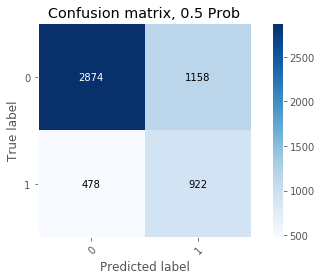

the Accuracy is: 0.698821796759941
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.71      0.78      4032
           1       0.44      0.66      0.53      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.65      0.69      0.65      5432
weighted avg       0.75      0.70      0.71      5432


******* Using Optimal Youden Classification Threshold *******


the Youden optimal index is : 0.50
Confusion matrix, without normalization
[[2888 1144]
 [ 479  921]]


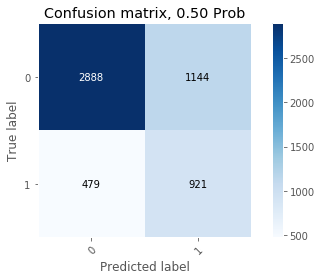

the Accuracy is: 0.7012150220913107
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78      4032
           1       0.45      0.66      0.53      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.65      0.69      0.66      5432
weighted avg       0.75      0.70      0.72      5432

time: 946 ms


In [218]:
# y_pred_random = rf_y_individual_pred
# y_proba_random = rf_y_individual_proba
# fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# #fpr, tpr, thresholds = metrics.roc_curve(y, rf_y_individual_proba, pos_label=1)
# roc_auc = metrics.auc(fpr, tpr)

# #making dataframe out of the thresholds
# xgb_roc= pd.DataFrame({"thresholds": thresholds,"fpr":fpr, "tpr": tpr})
# xgb_roc.iloc[0,0] =1
# xgb_roc['yuden']= xgb_roc['tpr']-xgb_roc['fpr']
# idx=xgb_roc['yuden'].idxmax()
# xgb_roc.iloc[idx,:]
# youden_threshold=xgb_roc.iloc[idx,0]

# roc_auc = metrics.auc(fpr, tpr)

# plt.title('ROC with optimal Youden Index')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.plot(xgb_roc.iloc[idx,1], xgb_roc.iloc[idx,2],marker='o', markersize=5, color="r", label="youden_optimal")
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


# #plotting confusion matrixs
# print("\n******* Using 0.5 Classification Threshold *******\n")
# np.set_printoptions(precision=2)
# plot_confusion_matrix(y, y_pred_random, title='Confusion matrix, 0.5 Prob')
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random))
# print ('the classification_report:\n', classification_report(y,y_pred_random))


# print("\n******* Using Optimal Youden Classification Threshold *******\n")
# print("\nthe Youden optimal index is : {:01.2f}".format(youden_threshold))
# y_pred_random_youden=y_proba_random.copy()
# y_pred_random_youden[y_pred_random_youden>=youden_threshold]=1
# y_pred_random_youden[y_pred_random_youden<youden_threshold]=0
# plot_confusion_matrix(y, y_pred_random_youden, title='Confusion matrix, {:01.2f} Prob'.format(youden_threshold))
# plt.show()
# print ('the Accuracy is:',accuracy_score(y, y_pred_random_youden))
# print ('the classification_report:\n', classification_report(y,y_pred_random_youden))

In [341]:
# #trying different cv algorithm

# from sklearn.model_selection import cross_val_score
# #clf = svm.SVC(kernel='linear', C=1)
# rf_random= RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
#             max_depth=10, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=4, min_samples_split=2)

# #making roc a scorer
# from sklearn.metrics import make_scorer
# scorer=make_scorer(roc_auc_score)

# scores = cross_val_score(rf_random, x, y, cv=5, scoring= scorer)
# scores     

array([0.62, 0.61, 0.63, 0.6 , 0.62])

time: 352 ms


## local model testing
*<del> step1) hypertune xgb on 5fold cv.

*<del> step2) test entire trainset and predict trainset.
    
*<del> step3) run hypertuned model on 5fold cv with lr and get overall metrics.
* step4) local model testing

In [363]:
z_icustay_id

0       200012
1       200014
2       200033
3       200036
4       200059
5       200063
6       200078
7       200091
8       200099
9       200108
10      200116
11      200141
12      200150
13      200188
14      200215
15      200231
16      200249
17      200265
18      200269
19      200312
20      200325
21      200328
22      200349
23      200350
24      200352
25      200361
26      200398
27      200399
28      200417
29      200439
         ...  
5402    299557
5403    299593
5404    299614
5405    299629
5406    299630
5407    299645
5408    299654
5409    299655
5410    299685
5411    299695
5412    299715
5413    299728
5414    299734
5415    299736
5416    299751
5417    299765
5418    299767
5419    299800
5420    299806
5421    299826
5422    299828
5423    299832
5424    299853
5425    299863
5426    299883
5427    299888
5428    299913
5429    299914
5430    299917
5431    299995
Name: icustay_id, Length: 5432, dtype: int64

time: 3.48 ms


In [381]:
def single_split_training(m=250, n_sfk_split=5):
       
    #######
    skf = StratifiedKFold(n_splits=n_sfk_split) #Stratified K-Folds cross-validator
    num_fold = 0
    
    for train_index, test_index in skf.split(x, y):
        X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
        y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold
    
    #######

        num_fold = num_fold + 1 ##silly to keep but it's from the loop
        print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 

        print('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

        ######
    
        indicator_time = 0 # the indicator
        for i, j in zip(test_z_icustay_id, test_index):  #looping through the zipped indicies of the test indicies/test icustay_id

            testing_sample_id = i #numerical index of first 1/2 of data ##??? this seems to be instead the    
            all_xy_0 = all_xy.loc[train_z_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
            all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

            ###important parameter. was at 400, i changed to X
            m = m  # m is the number of similar cases or similar controls

            X_test_00 = x[j]
            y_test = y[j]

            X_test = X_test_00.reshape(1, -1)

            # print 'start selecting......'

            Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

            ix = np.isin(z_icustay_id, Id_train_set)
            Id_train_set_index = list(np.where(ix))

            # Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

            X_train = x[Id_train_set_index]
            y_train = y[Id_train_set_index]

            #print('start training......')

            # scoring = 'roc_auc'

        # xgboost
        
            #hyper parameter tuning F1 from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning F1_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 1}
            #hyper parameter tuning recall_macro from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 5}
            #hyper parameter tuning neg_log_loss from gridsearchCV on 5cv:{'learning_rate': 0.1, 'max_depth': 2, 'scale_pos_weight': 1}


            xgboost_mod = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2,
                          min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                          objective='binary:logistic', nthread=-1, scale_pos_weight=1, seed=27)
            xgboost_mod.fit(x[Id_train_set_index], y[Id_train_set_index])
            xg_y_pred = xgboost_mod.predict(X_test)
            xg_y_pred_proba = xgboost_mod.predict_proba(X_test)[:,1]

            xg_one_fold_pred.append(xg_y_pred)
            xg_one_fold_proba.append(xg_y_pred_proba)

        # lr 

            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(x[Id_train_set_index], y[Id_train_set_index])
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1
            # print 'the next testing sample and total samples:', indicator_time, test_index.size

        xg_y_individual_pred = np.array(xg_one_fold_pred)
        xg_y_individual_proba = np.array(xg_one_fold_proba)

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        one_fold_y_test = y[test_index]

        print ('---------new fold---------------')
        print ('**** result of non-individual predictor using xgboost:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], xg_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], xg_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], xg_y_individual_pred))
        print(confusion_matrix(y[test_index], xg_y_individual_pred))
        print("\n")

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))
        print("\n")

time: 252 ms


In [ ]:
#do we have multiple models for each patient? if so how do we aggregate?

In [382]:
single_split_training(m=250,n_sfk_split=2 )

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 2716
---------new fold---------------
**** result of non-individual predictor using xgboost:
the Accuracy of one fold: 0.6299705449189985
the AUC of one fold: 0.6565575396825396
the classification_report :               precision    recall  f1-score   support

           0       0.86      0.60      0.71      2016
           1       0.38      0.71      0.50       700

   micro avg       0.63      0.63      0.63      2716
   macro avg       0.62      0.66      0.60      2716
weighted avg       0.73      0.63      0.65      2716

[[1213  803]
 [ 202  498]]


****this is the result of individual predictor using lr:
the Accuracy of one fold: 0.6642120765832106
the AUC of one fold: 0.6656349206349206
the classification_report :               precision    recall  f1-score   support

           0       0.85      0.66      0.75      2016
           1       0.41      0.67      0.51       700

   micro avg  

In [383]:
single_split_training(m=500,n_sfk_split=2 )

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 2716
---------new fold---------------
**** result of non-individual predictor using xgboost:
the Accuracy of one fold: 0.45544918998527245
the AUC of one fold: 0.603343253968254
the classification_report :               precision    recall  f1-score   support

           0       0.90      0.30      0.45      2016
           1       0.31      0.91      0.46       700

   micro avg       0.46      0.46      0.46      2716
   macro avg       0.61      0.60      0.46      2716
weighted avg       0.75      0.46      0.45      2716

[[ 601 1415]
 [  64  636]]


****this is the result of individual predictor using lr:
the Accuracy of one fold: 0.5474963181148749
the AUC of one fold: 0.6480952380952382
the classification_report :               precision    recall  f1-score   support

           0       0.90      0.44      0.59      2016
           1       0.35      0.86      0.49       700

   micro avg  

KeyboardInterrupt: 

time: 1h 4min 22s


In [471]:
# testing the select train set fxn:
icustay_id= z_icustay_id

#######
skf = StratifiedKFold(n_splits=4) #Stratified K-Folds cross-validator
num_fold = 0

for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    ######

    indicator_time = 0 # the indicator
    ##looping through the zipped indicies of the test_icustay and test row index.
    for i, j in zip(test_icustay_id, test_index): 

        #these three lines: for each sample in the test set individually, go through and add the test sample to the training data.
        testing_sample_id = i #   
        all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
        all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

        
        
        ###important parameter. was at 400, i changed to X
        m = m  # m is the number of similar cases or similar controls

        X_test_00 = x[j]
        y_test = y[j]

        X_test = X_test_00.reshape(1, -1)

        # print 'start selecting......'

        Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 1358


KeyboardInterrupt: 

time: 1min 32s


In [468]:
#trying to collapse to get just 1 cv split index

skf = StratifiedKFold(n_splits=4, random_state=12345) #Stratified K-Folds cross-validator
num_fold = 0

#train_index, test_index in skf.split(x, y):

#splitting_test= skf.split(x,y)
#splitting_test.split(X, y[, groups])
for train_index, test_index in skf.split(x, y):
    print(train_index, test_index)
print(train_index, test_index)
    
#     X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
#     y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

#     num_fold = num_fold + 1 ##silly to keep but it's from the loop
#     print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
#     print('the number of testing samples in this fold:', test_index.size)

#     train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
#     test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

#     xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
#     xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

#     lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
#     lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

[1341 1342 1344 ... 5429 5430 5431] [   0    1    2 ... 1394 1395 1400]
[   0    1    2 ... 5429 5430 5431] [1341 1342 1344 ... 2764 2768 2769]
[   0    1    2 ... 5429 5430 5431] [2697 2698 2699 ... 4079 4080 4082]
[   0    1    2 ... 4079 4080 4082] [4043 4053 4057 ... 5429 5430 5431]
[   0    1    2 ... 4079 4080 4082] [4043 4053 4057 ... 5429 5430 5431]
time: 16.5 ms


In [469]:
for train_index, test_index in skf.split(x, y):
    X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
    y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

    num_fold = num_fold + 1 ##silly to keep but it's from the loop
    print('this is the results of the {} fold in 5 folds:'.format(num_fold)) 
    print('the number of testing samples in this fold:', test_index.size)

    train_icustay_id = icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_icustay_id = icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 1358


TypeError: only integer scalar arrays can be converted to a scalar index

time: 22.2 ms


In [465]:
X_train_0, X_test_0 = x[train_index], x[test_index] #assigning x_train and x_test sets within this cv fold
y_train_0, y_test_0 = y[train_index], y[test_index] #assigning y_train and y_test sets within this cv fold

train_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
test_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

indicator_time = 0 # the indicator
##looping through the zipped indicies of the test_icustay and test row index.
for testing_sample_id, testing_index_id in zip(test_icustay_id, test_index): 

    #these 2 lines: for each sample in the test set individually, go through and add the test sample to the training data.
    all_xy_0 = all_xy.loc[train_icustay_id] # select all TRAINING samples from  the current fold using icustay_id index
    all_xy_training = all_xy_0.append(all_xy.loc[i]) # append the current ith testing sample to the training set. 

    
    
#     ###important parameter. was at 400, i changed to X
#     m = m  # m is the number of similar cases or similar controls

    X_test = x[testing_index_id].reshape(1,-1) #changed x_test_00 to this and made it more easy to understand. array[[xtest]]. 
                                #single sample being tested for
    y_test = y[testing_index_id] #the y label

#     # print 'start selecting......'

#     Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  #  individulization
m=200

#so gets the 200 closest training and 200 closest grower testing samples
Id_train_set = select_train_samples(testing_sample_id, all_xy_training, m, time_interval)  
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    
# ix = np.isin(z_icustay_id, Id_train_set) #boolean vector where TRUE = for the m * 2 samples
# Id_train_set_index = list(np.where(ix))
# Id_train_set_index = np.argwhere(z_icustay_id == Id_train_set)

X_train = x[ix]# x[Id_train_set_index]
y_train = y[ix]# y[Id_train_set_index]

KeyError: 'the label [251051] is not in the [index]'

time: 6.27 s


In [473]:
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
num_splits=5
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # note that , containing the i
        

        m = 200  # m is the number of similar cases or similar controls

        X_test = x[testing_sample_index].reshape(1, -1)
        y_test = y[testing_sample_index]

        # print 'start selecting......'

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: so all testing icu's
        #all_xy_training:all training rows except with the single test sample appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of 200 closest training and 200 closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set
        
        ######modeling####
        
        ###logistic regression
        

        logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                    intercept_scaling=1, class_weight='balanced', random_state=None)
        logreg.fit(X_train, y_train)
        lr_y_pred = logreg.predict(X_test)
        lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

        lr_one_fold_pred.append(lr_y_pred)
        lr_one_fold_proba.append(lr_y_pred_proba)

        indicator_time = indicator_time + 1
    
    lr_y_individual_pred = np.array(lr_one_fold_pred)
    lr_y_individual_proba = np.array(lr_one_fold_proba)
    
    one_fold_y_test = y[test_index]
    print ('****this is the result of individual predictor using lr:')
    print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
    print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
    print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
    print(confusion_matrix(y[test_index], lr_y_individual_pred))


***************
#####################
this is the results of the 1 fold in 5 folds:
the number of testing samples in this fold: 1087
****this is the result of individual predictor using lr:
the Accuracy of one fold: 0.6734130634774609
the AUC of one fold: 0.626119667197734
the classification_report :               precision    recall  f1-score   support

           0       0.82      0.72      0.77       807
           1       0.40      0.53      0.45       280

   micro avg       0.67      0.67      0.67      1087
   macro avg       0.61      0.63      0.61      1087
weighted avg       0.71      0.67      0.69      1087

[[584 223]
 [132 148]]
***************
#####################
this is the results of the 2 fold in 5 folds:
the number of testing samples in this fold: 1087
****this is the result of individual predictor using lr:
the Accuracy of one fold: 0.6973321067157314
the AUC of one fold: 0.6620530182333156
the classification_report :               precision    recall  f1-score  

In [592]:
def local_model(num_splits=2, m=200):
    
    """
    algorithm: first split into train and test set for cv: 
        now have full x, full y, xtrain/ytrain, xtest/ytest for each cv split.
        
        loop through each row in xtest:
            take the current xtest iteration and add it to all xtrain.
            find the M closest other rows based on grower distance.
            take these M rows and train a model on their features and outcome.
            use this model to predict the current xtest iteration. 
            add this prediction to a datastructure
    
    """
    
    time_interval = 24  # ,48,72,96,120,144]:
    #x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
    #num_splits=5
    skf = StratifiedKFold(n_splits=num_splits)
    num_fold = 0
    for train_index, test_index in skf.split(x, y):
        print ('***************')
        # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
        X_train_0, X_test_0 = x[train_index], x[test_index]
        y_train_0, y_test_0 = y[train_index], y[test_index]

        print( '#####################')

        num_fold = num_fold + 1
        print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

        print ('the number of testing samples in this fold:', test_index.size)

        train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
        test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

        xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
        xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

        lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
        lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr
        
        lr_all_pred= []
        lr_all_proba= []

        indicator_time = 0 # the indicator
        for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

            xy_cv = all_xy.iloc[train_index] # select training samples from  5 fold
            xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

            #the clinical data for the single test sample in current iteration.
            X_test = x[testing_sample_index].reshape(1, -1) #single 
            y_test = y[testing_sample_index]
            if indicator_time%50==0:
                print("indicator_time:",indicator_time)
            else:
                pass

            Id_train_set = select_train_samples(testing_sample_icu, xy_training, m, time_interval)  #  individulization
            """
            #testing_sample_icu: single icustay_id of a patient.
            #all_xy_training:all training rows except with the single test sample in question appended
            #m: #
            #time_interval:w/e
            ##output: icustay_id of M closest training and M closest grower testing samples
            """
            ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
            X_train=x[ix]# parameters for m*2 training set
            y_train=y[ix]# labels for m*2 training set
            
            if indicator_time%50==0:
                print("x_train, y_train len:",len(X_train), len(y_train))
            else:
                pass

            ######modeling####

            ###logistic regression


            logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                        intercept_scaling=1, class_weight='balanced', random_state=None)
            logreg.fit(X_train, y_train)
            lr_y_pred = logreg.predict(X_test)
            lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

            lr_one_fold_pred.append(lr_y_pred)
            lr_one_fold_proba.append(lr_y_pred_proba)
            
            lr_all_pred.append(lr_y_pred)
            lr_all_proba.append(lr_y_pred_proba)

            indicator_time = indicator_time + 1

        lr_y_individual_pred = np.array(lr_one_fold_pred)
        lr_y_individual_proba = np.array(lr_one_fold_proba)

        print ('****this is the result of individual predictor using lr:')
        print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
        print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
        print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
        print(confusion_matrix(y[test_index], lr_y_individual_pred))


time: 135 ms


In [602]:
#trying to implement without cv.   
time_interval = 24  # ,48,72,96,120,144]:

#m=200

train_z_icustay_id = z_icustay_id # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

lr_all_pred= []
lr_all_proba= []

indicator_time = 0 # the indicator
for testing_sample_icu, testing_sample_index in zip(z_icustay_id, range(0,len(z_icustay_id))):

#     xy_cv = all_xy.drop(train_index, axis=0) # select training samples from  5 fold
#     xy_training = xy_cv.append(xy_cv.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

    #the clinical data for the single test sample in current iteration.
    X_test = x[testing_sample_index].reshape(1, -1) #single 
    y_test = y[testing_sample_index]
    if indicator_time%50==0:
        print("indicator_time:",indicator_time)
    else:
        pass

    Id_train_set = select_train_samples(testing_sample_icu, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_icu: single icustay_id of a patient.
    #all_xy_training:all training rows except with the single test sample in question appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of M closest training and M closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####

    ###logistic regression


    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    lr_all_pred.append(lr_y_pred)
    lr_all_proba.append(lr_y_pred_proba)
    
    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

indicator_time: 0
indicator_time: 50
indicator_time: 100
indicator_time: 150
indicator_time: 200
indicator_time: 250
indicator_time: 300
indicator_time: 350
indicator_time: 400
indicator_time: 450
indicator_time: 500
indicator_time: 550
indicator_time: 600
indicator_time: 650
indicator_time: 700
indicator_time: 750
indicator_time: 800
indicator_time: 850
indicator_time: 900
indicator_time: 950
indicator_time: 1000
indicator_time: 1050
indicator_time: 1100
indicator_time: 1150
indicator_time: 1200
indicator_time: 1250
indicator_time: 1300
indicator_time: 1350
indicator_time: 1400
indicator_time: 1450
indicator_time: 1500
indicator_time: 1550
indicator_time: 1600
indicator_time: 1650
indicator_time: 1700
indicator_time: 1750
indicator_time: 1800
indicator_time: 1850
indicator_time: 1900
indicator_time: 1950
indicator_time: 2000
indicator_time: 2050
indicator_time: 2100
indicator_time: 2150
indicator_time: 2200
indicator_time: 2250
indicator_time: 2300
indicator_time: 2350
indicator_time:

ValueError: Found input variables with inconsistent numbers of samples: [2716, 5432]

time: 2h 27min 21s


In [658]:
m

200

time: 2.01 ms


In [603]:
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y, lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y, lr_y_individual_pred))
print ('the classification_report :', classification_report(y, lr_y_individual_pred))
print(confusion_matrix(y, lr_y_individual_pred))

****this is the result of individual predictor using lr:
the Accuracy of one fold: 0.695139911634757
the AUC of one fold: 0.645203373015873
the classification_report :               precision    recall  f1-score   support

           0       0.82      0.75      0.78      4032
           1       0.43      0.54      0.48      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.63      0.65      0.63      5432
weighted avg       0.72      0.70      0.71      5432

[[3017 1015]
 [ 641  759]]
time: 18.9 ms


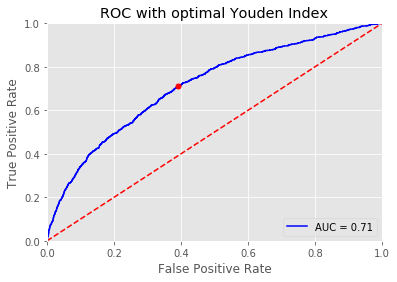


******* Using 0.5 Classification Threshold *******
[[3017 1015]
 [ 641  759]]
the Accuracy is: 0.695139911634757
the classification_report:
               precision    recall  f1-score   support

           0       0.82      0.75      0.78      4032
           1       0.43      0.54      0.48      1400

   micro avg       0.70      0.70      0.70      5432
   macro avg       0.63      0.65      0.63      5432
weighted avg       0.72      0.70      0.71      5432


******* Using Optimal Youden Classification Threshold *******
the Youden optimal index is : 0.15
[[2451 1581]
 [ 403  997]]
the Accuracy is: 0.6347569955817378
the classification_report:
               precision    recall  f1-score   support

           0       0.86      0.61      0.71      4032
           1       0.39      0.71      0.50      1400

   micro avg       0.63      0.63      0.63      5432
   macro avg       0.62      0.66      0.61      5432
weighted avg       0.74      0.63      0.66      5432

time: 187 ms


In [657]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x, y=y, pos_label=1, print_default=True, print_classification_table=True)

In [601]:
all_xy.iloc[-5]

,amax_bun,amax_creatinine,amax_daily_sofa,amax_heartrate,amax_meanartpress,amax_platelet,amax_ptt,amax_sysbp,amax_temperature,amin_bun,...,any_vasoactive_False,any_vasoactive_True,leukocyte_False,leukocyte_True,"pao2fio2Ratio_(0, 200]","pao2fio2Ratio_(200, 333]","pao2fio2Ratio_(333, 475]","pao2fio2Ratio_(475, 3000]",vent_recieved_False,vent_recieved_True
icustay_id,,,,,,,,,,,,,,,,,,,,,
299888,-0.049870,-0.079914,0.500000,0.080295,0.098730,0.016643,-0.051765,0.041019,0.063709,-0.131174,...,0,1,1,0,0,1,0,0,1,0
299913,0.484876,0.631709,0.160964,0.112596,0.072439,0.113523,-0.025534,0.071275,0.017923,0.420338,...,1,0,1,0,0,0,0,1,0,1
299914,0.350242,2.641747,0.160964,0.047458,0.032467,0.089790,0.015733,0.063509,0.009804,0.208459,...,1,0,1,0,0,0,0,1,1,0
299917,-0.405288,-0.253202,-0.500000,0.056759,0.016634,-0.035398,0.012640,-0.028245,0.071521,-0.464272,...,1,0,1,0,0,0,0,1,1,0
299995,-0.355418,-0.164150,-1.000000,0.050589,0.072439,0.064529,0.012640,0.071275,0.034019,-0.355418,...,1,0,1,0,0,0,0,1,0,1


time: 17.4 ms


In [593]:


#Id_train_set

#Id_train_set.isin(z_icustay_id[train_index])

len(set(Id_train_set) & set(z_icustay_id[train_index]))  #400

# len(set(Id_train_set) & set(z_icustay_id[test_index]))  #0

# #Id_train_set is in z_icustay_id[train_index]
#z_icustay_id[test_index]

400

time: 5.66 ms


In [594]:
#ix = np.isin(z_icustay_id, Id_train_set) #boolean vector of which samples are in the train set
len(x[np.isin(z_icustay_id, Id_train_set)])# parameters for m*2 training set
#y_train=y[ix]# labels for m*2 training set

400

time: 3.45 ms


In [545]:
len(X_train) #40
len(y_train) #40

40

time: 2.37 ms


In [557]:
X_test

array([[ 0.78,  0.4 ,  0.09,  0.14,  0.  , -0.09,  0.08,  0.1 , -0.11,
         1.  ,  0.  ,  1.  ,  0.  ]])

time: 2.04 ms


In [549]:
len(x[ix])

40

time: 2.75 ms


In [552]:
#[1 if y >= youden_threshold else 0 for y in y_proba]
sum([1 if x==True else 0 for x in ix])

40

time: 9.55 ms


200

time: 2.41 ms


In [551]:
len(ix)

5432

time: 2.12 ms


In [543]:
# len(x) #5432
#len(y[test_index]) #2716
#len(lr_y_individual_proba) #1086

5432

time: 2.2 ms


In [527]:
y_test

0

time: 2.16 ms


In [537]:
testing_sample_icu=299751
testing_sample_index=5416
test_output=select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)
len(test_output) #400

400

time: 1.69 s


In [523]:
len(all_xy_cv)
print(len(y[test_index]), len(lr_y_individual_pred))

1086 1086
time: 1.51 ms


In [497]:
local_model(num_splits=2, m=50)

***************
#####################
this is the results of the 1 fold in 2 folds:
the number of testing samples in this fold: 2716
indicator_time: 0
indicator_time: 50
indicator_time: 100
indicator_time: 150
indicator_time: 200
indicator_time: 250
indicator_time: 300
indicator_time: 350
indicator_time: 400
indicator_time: 450
indicator_time: 500
indicator_time: 550
indicator_time: 600
indicator_time: 650
indicator_time: 700
indicator_time: 750
indicator_time: 800
indicator_time: 850
indicator_time: 900
indicator_time: 950
indicator_time: 1000
indicator_time: 1050
indicator_time: 1100
indicator_time: 1150
indicator_time: 1200
indicator_time: 1250
indicator_time: 1300
indicator_time: 1350
indicator_time: 1400
indicator_time: 1450
indicator_time: 1500
indicator_time: 1550
indicator_time: 1600
indicator_time: 1650
indicator_time: 1700
indicator_time: 1750
indicator_time: 1800
indicator_time: 1850
indicator_time: 1900
indicator_time: 1950
indicator_time: 2000
indicator_time: 2050
indicato

In [520]:
lr_one_fold_proba

[array([0.01]), array([0.04]), array([0.18]), array([0.01]), array([0.98])]

time: 2.77 ms


In [516]:
#debugging siz of X_train and y_train
num_splits=2
m=200
time_interval = 24  # ,48,72,96,120,144]:
#x, y, z_icustay_id, all_xy = preprocessing(folder, time_interval)  # all_xy is for compute gower distance
#num_splits=5
skf = StratifiedKFold(n_splits=num_splits)
num_fold = 0
for train_index, test_index in skf.split(x, y):
    print ('***************')
    # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
    X_train_0, X_test_0 = x[train_index], x[test_index]
    y_train_0, y_test_0 = y[train_index], y[test_index]

    print( '#####################')

    num_fold = num_fold + 1
    print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

    print ('the number of testing samples in this fold:', test_index.size)

    train_z_icustay_id = z_icustay_id[train_index] # the icustay_id of samples in training set from 5 fold
    test_z_icustay_id = z_icustay_id[test_index] # the icustay_id of samples in testing set from 5 fold

    xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
    xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

    lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
    lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

    indicator_time = 0 # the indicator
    for testing_sample_icu, testing_sample_index in zip(test_z_icustay_id, test_index):

        all_xy_cv = all_xy.loc[train_z_icustay_id] # select training samples from  5 fold
        all_xy_training = all_xy_cv.append(all_xy.loc[testing_sample_icu]) # append current iteration single test sample to all trainings

        #the clinical data for the single test sample in current iteration.
        X_test = x[testing_sample_index].reshape(1, -1) #single 
        y_test = y[testing_sample_index]
        if indicator_time%50==0:
            print("indicator_time:",indicator_time)
        else:
            pass

        Id_train_set = select_train_samples(testing_sample_icu, all_xy_training, m, time_interval)  #  individulization
        """
        #testing_sample_icu: single icustay_id of a patient.
        #all_xy_training:all training rows except with the single test sample in question appended
        #m: #
        #time_interval:w/e
        ##output: icustay_id of M closest training and M closest grower testing samples
        """
        ix = np.isin(z_icustay_id, Id_train_set)
        X_train=x[ix]# parameters for m*2 training set
        y_train=y[ix]# labels for m*2 training set

2716

time: 3.31 ms


In [655]:
classifier_eval2(y_proba=lr_y_individual_proba , x=x[test_index], y=y[test_index], pos_label=1, print_default=True, print_classification_table=False)

ValueError: Found input variables with inconsistent numbers of samples: [2716, 5432]

time: 43.7 ms


In [ ]:
#next step, visualize each of the patient groups on the pca plot.

In [490]:
# time_interval = 24  # ,48,72,96,120,144]:
# num_splits=5
# skf = StratifiedKFold(n_splits=num_splits)
# num_fold = 0
# for train_index, test_index in skf.split(x, y):
#     print ('***************')
#     # print 'This is the '+ str(i)+' times result of '+str(n_fold)+' fold'
#     X_train_0, X_test_0 = x[train_index], x[test_index]
#     y_train_0, y_test_0 = y[train_index], y[test_index]

print( '#####################')

#num_fold = num_fold + 1
#print ('this is the results of the %d fold in %s folds:' %(num_fold,num_splits))

#print ('the number of testing samples in this fold:', test_index.size)

train_z_icustay_id = z_icustay_id#[train_index] # the icustay_id of samples in training set from 5 fold
test_z_icustay_id = z_icustay_id#[test_index] # the icustay_id of samples in testing set from 5 fold

xg_one_fold_pred = [] # obtain the pred label of testing samples for one fold using xgboost
xg_one_fold_proba = [] # obtain the proba  of testing samples for one fold using xgboost

lr_one_fold_pred = [] # obtain the pred label of testing samples for one fold using lr
lr_one_fold_proba = [] # obtain the proba  of testing samples for one fold using lr

indicator_time = 0 # the indicator



for testing_sample_id, testing_sample_icu in zip(z_icustay_id, range(0,len(x))):
    m = 20  # m is the number of similar cases or similar controls

    X_test = x[testing_sample_icu].reshape(1, -1)
    y_test = y[testing_sample_icu]

    print('start selecting......')
    print("length xtest:",len(X_test))

    Id_train_set = select_train_samples(testing_sample_id, all_xy, m, time_interval)  #  individulization
    """
    #testing_sample_id: so all testing 
    #all_xy_training:all training rows except with the single test sample appended
    #m: #
    #time_interval:w/e
    ##output: icustay_id of 200 closest training and 200 closest grower testing samples
    """
    ix = np.isin(z_icustay_id, Id_train_set)
    X_train=x[ix]# parameters for m*2 training set
    y_train=y[ix]# labels for m*2 training set

    ######modeling####
    ###logistic regression

    logreg = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=10, fit_intercept=True,
                                intercept_scaling=1, class_weight='balanced', random_state=None)
    logreg.fit(X_train, y_train)
    lr_y_pred = logreg.predict(X_test)
    lr_y_pred_proba = logreg.predict_proba(X_test)[:,1]

    lr_one_fold_pred.append(lr_y_pred)
    lr_one_fold_proba.append(lr_y_pred_proba)

    indicator_time = indicator_time + 1

lr_y_individual_pred = np.array(lr_one_fold_pred)
lr_y_individual_proba = np.array(lr_one_fold_proba)

one_fold_y_test = y[test_index]
print ('****this is the result of individual predictor using lr:')
print ('the Accuracy of one fold:', accuracy_score(y[test_index], lr_y_individual_pred))
print ('the AUC of one fold:', roc_auc_score(y[test_index], lr_y_individual_pred))
print ('the classification_report :', classification_report(y[test_index], lr_y_individual_pred))
print(confusion_matrix(y[test_index], lr_y_individual_pred))

#####################
start selecting......
length xtest: 1
start selecting......
length xtest: 1
start selecting......
length xtest: 1
start selecting......
length xtest: 1
start selecting......
length xtest: 1
start selecting......
length xtest: 1


KeyboardInterrupt: 

time: 9.41 s
